In [1]:
from pathlib import Path
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.util import hellinger_distance
import ast

import xgi

In [2]:
def _parse_members(raw):
    if pd.isna(raw):
        return []
    try:
        members = ast.literal_eval(str(raw))
        return list(members)
    except (SyntaxError, ValueError, TypeError):
        return []
    
def parse_hyperedges(raw):
    if raw is None:
        return []
    # already a numpy array/list
    if isinstance(raw, (list, tuple, np.ndarray)):
        iterable = raw
    else:
        text = str(raw).strip()
        if text.startswith("array(") and text.endswith(")"):
            text = text[len("array("):-1]   # remove leading "array(" and trailing ")"
        try:
            iterable = ast.literal_eval(text)
        except (SyntaxError, ValueError):
            return []

    edges = []
    for item in iterable:
        if isinstance(item, (list, tuple)):
            edges.append(tuple(item))
        else:
            try:
                edges.append(tuple(ast.literal_eval(str(item))))
            except (SyntaxError, ValueError):
                continue
    return edges
def parse_node_labels(value):
    if isinstance(value, (list, tuple)):
        items = value
    else:
        try:
            items = ast.literal_eval(str(value))
        except (SyntaxError, ValueError):
            return []

    if not items:
        return []

    inner = items[0]
    if isinstance(inner, (list, tuple)):
        return list(inner)
    if isinstance(inner, str):
        try:
            return list(ast.literal_eval(inner))
        except (SyntaxError, ValueError):
            return []

    return list(inner)

# Toy Example
Generate unifrom and non-uniform HSBM.
- visualize the hypergraph, color the edges using HLRC value 
- compare HLRC, HORC, HFRC


## U-HSBM

In [ ]:
DATA_PATH = Path('derived_data/u_hsbm_toy_curv.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Dataset not found at {DATA_PATH!s}. Make sure `generate_hsbm.py` and curvature scripts have been executed.')

u_df = pd.read_csv(DATA_PATH)
u_df = u_df.rename(columns={"horc_uw_star_max_a0p1":"horc"})
# take one hypergraph as an example
u_toy = u_df[u_df.hg_idx==0][['members','edge_label',"hlrc","horc","hfrc"]]

u_toy.head()

,members,edge_label,hlrc,horc,hfrc
0,"['0', '1', '3']",intra,0.152778,0.531737,-23
1,"['0', '3', '14']",intra,0.117521,0.554653,-25
2,"['0', '4', '6']",intra,-0.025000,0.282849,-17
3,"['0', '6', '13']",intra,-0.161111,0.462817,-16
4,"['0', '9', '10']",intra,-0.025000,0.401239,-23


### Hypergraph Visualization + Boxlots

In [65]:
hyperedges = parse_hyperedges(np.array(u_toy.members))

H = xgi.Hypergraph(hyperedges)
# node position
pos = xgi.barycenter_spring_layout(H, seed=123, iterations=500)
# edge color
cmap = matplotlib.colormaps.get_cmap('RdYlBu_r')
edge_color = {key: cmap((cuvr+1)/2) for key, cuvr in enumerate(u_toy.hlrc)}


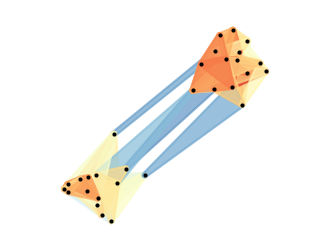

In [71]:
# hypergraph plot
fig, ax = plt.subplots(figsize=(4, 3))
xgi.draw(H, pos=pos, node_size=3, node_lw = 0, node_ec = "black", node_fc = 'black',
         edge_fc = edge_color, edge_ec = edge_color, dyad_color = edge_color, dyad_lw = 1,
         alpha=0.7, hull = True, radius = 0.02, rescale_sizes=False);
plt.savefig("figures/u_toy.pdf")

/var/folders/16/jlsyc7md1jsb09sts0bhmkl40000gn/T/ipykernel_6315/1207690703.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8)


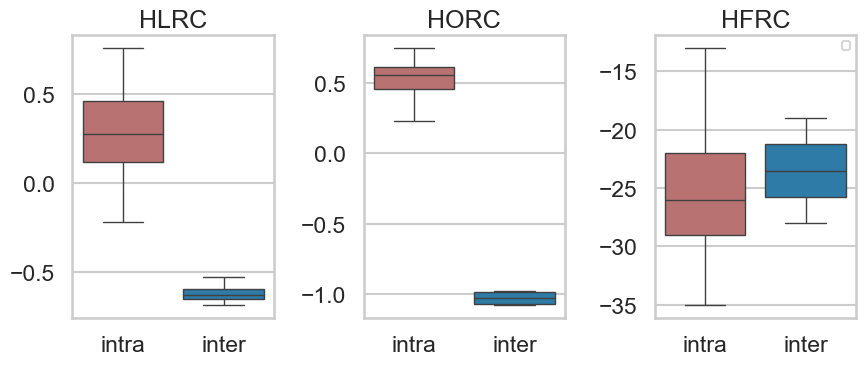

In [72]:
# curvature boxplot
sns.set_theme(style='whitegrid', context='talk')
fig, axes = plt.subplots(1, 3, figsize=(3 * 3, 4), sharey=False)
palette = {
    'intra': '#c46666',
    'inter': '#1a80bb'
}
nu_plot_df = u_toy.melt(
    id_vars="edge_label",
    value_vars=["hlrc","horc","hfrc"],
    var_name='curvature_type',
    value_name='curvature'
).dropna(subset=['curvature'])

for ax, curv in zip(axes, ["hlrc","horc","hfrc"]):
    data = nu_plot_df[nu_plot_df['curvature_type'] == curv]
    sns.boxplot(
        data=data,
        x='edge_label',
        y='curvature',
        hue='edge_label',
        ax=ax,
        palette=palette,
        order=['intra', 'inter'],
        hue_order=['intra', 'inter'],
        showfliers=True
    )
    ax.set_title(curv.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()
ax.legend(fontsize=8)

fig.tight_layout()
plt.savefig("figures/u_toy_boxplot.pdf")
plt.show()

### Hellinger distance

In [79]:
print("Hellinger distance")
for curvature in ["hlrc","horc","hfrc"]:
    data = u_toy[['edge_label', curvature]].dropna()
    inter = data.loc[data['edge_label'] == 'inter', curvature].to_numpy()
    intra = data.loc[data['edge_label'] == 'intra', curvature].to_numpy()
    if len(inter) == 0 or len(intra) == 0:
        continue
    distance = hellinger_distance(intra, inter)
    print(f" {curvature.upper()}: {distance:.4f}")


Hellinger distance
 HLRC: 1.0000
 HORC: 1.0000
 HFRC: 0.7531


## NU-HSBM

In [ ]:
DATA_PATH = Path('derived_data/nu_hsbm_curv.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Dataset not found at {DATA_PATH!s}. Make sure `generate_hsbm.py` and curvature scripts have been executed.')

nu_df = pd.read_csv(DATA_PATH)

# take one hypergraph as an example
nu_toy = nu_df[nu_df.hg_idx==0][['members','edge_label',"hlrc","horc","hfrc"]]

nu_toy.head()

,members,edge_label,hlrc,horc,hfrc
0,"['p0', 'p15', 'p16', 'p19', 'p2']",intra,-0.068357,0.576230,-50
1,"['p0', 'p24']",inter,-0.665635,-0.134572,-20
2,"['p1', 'p17', 'p7']",intra,0.163715,0.565077,-28
3,"['p0', 'p1', 'p18', 'p8']",intra,-0.317590,0.513092,-32
4,"['p0', 'p10', 'p12', 'p15']",intra,-0.094853,0.579255,-30


### Hypergraph visualization + Boxplots

In [74]:
hyperedges = parse_hyperedges(np.array(nu_toy.members))

H = xgi.Hypergraph(hyperedges)
# node position
pos = xgi.barycenter_spring_layout(H, seed=123, iterations=500)
# edge color
cmap = matplotlib.colormaps.get_cmap('RdYlBu_r')
edge_color = {key: cmap((cuvr+1)/2) for key, cuvr in enumerate(nu_toy.hlrc)}


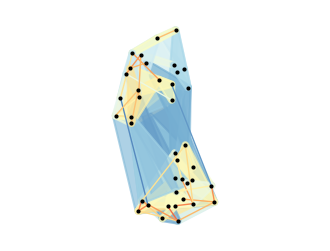

In [75]:
# hypergraph plot
fig, ax = plt.subplots(figsize=(4, 3))
xgi.draw(H, pos=pos, node_size=3, node_lw = 0, node_ec = "black", node_fc = 'black',
         edge_fc = edge_color, edge_ec = edge_color, dyad_color = edge_color, dyad_lw = 1,
         alpha=0.7, hull = True, radius = 0.02, rescale_sizes=False);
plt.savefig("figures/nu_toy.pdf")

/var/folders/16/jlsyc7md1jsb09sts0bhmkl40000gn/T/ipykernel_6315/345519394.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8)


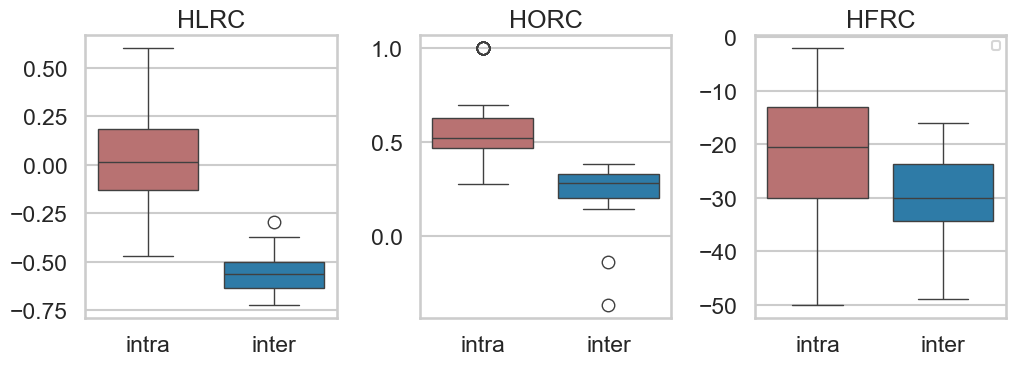

In [76]:
# curvature boxplot
sns.set_theme(style='whitegrid', context='talk')
fig, axes = plt.subplots(1, 3, figsize=(3.5 * 3, 4), sharey=False)
palette = {
    'intra': '#c46666',
    'inter': '#1a80bb'
}
nu_plot_df = nu_toy.melt(
    id_vars="edge_label",
    value_vars=["hlrc","horc","hfrc"],
    var_name='curvature_type',
    value_name='curvature'
).dropna(subset=['curvature'])

for ax, curv in zip(axes, ["hlrc","horc","hfrc"]):
    data = nu_plot_df[nu_plot_df['curvature_type'] == curv]
    sns.boxplot(
        data=data,
        x='edge_label',
        y='curvature',
        hue='edge_label',
        ax=ax,
        palette=palette,
        order=['intra', 'inter'],
        hue_order=['intra', 'inter'],
        showfliers=True
    )
    ax.set_title(curv.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()
ax.legend(fontsize=8)

fig.tight_layout()
plt.savefig("figures/nu_toy_boxplot.pdf")
plt.show()

### Hellinger distance

In [81]:
print("Hellinger distance")
for curvature in ["hlrc","horc","hfrc"]:
    data = nu_toy[['edge_label', curvature]].dropna()
    inter = data.loc[data['edge_label'] == 'inter', curvature].to_numpy()
    intra = data.loc[data['edge_label'] == 'intra', curvature].to_numpy()
    if len(inter) == 0 or len(intra) == 0:
        continue
    distance = hellinger_distance(intra, inter)
    print(f" {curvature.upper()}: {distance:.4f}")


Hellinger distance
 HLRC: 0.9723
 HORC: 0.9752
 HFRC: 0.7346


# Extra U-HSBM cases

In [6]:
DATA_PATH = Path('derived_data/u_hsbm_toy_curv.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Dataset not found at {DATA_PATH!s}. Make sure `generate_hsbm.py` and curvature scripts have been executed.')

u_df = pd.read_csv(DATA_PATH)
u_df = u_df.rename(columns={"horc_uw_star_max_a0p1":"horc"})
u_df

,hg_idx,config_name,edge,members,hlrc,horc,hfrc,edge_label,k_uniform,num_comms,block_sizes,community_edge_probs,seed,node_labels
0,0,k3_two_comm,0,"['0', '1', '3']",0.152778,0.531737,-23,intra,3,2,15|15,0.1|0.001,123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,k3_two_comm,1,"['0', '3', '14']",0.117521,0.554653,-25,intra,3,2,15|15,0.1|0.001,123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,k3_two_comm,2,"['0', '4', '6']",-0.025000,0.282849,-17,intra,3,2,15|15,0.1|0.001,123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,k3_two_comm,3,"['0', '6', '13']",-0.161111,0.462817,-16,intra,3,2,15|15,0.1|0.001,123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,k3_two_comm,4,"['0', '9', '10']",-0.025000,0.401239,-23,intra,3,2,15|15,0.1|0.001,123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,7,k4_three_comm_unbalanced,1520,"['79', '80', '85', '89']",-0.401796,0.455569,-84,intra,4,3,40|30|20,0.01|0.0001|0.0001,123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5333,7,k4_three_comm_unbalanced,1521,"['79', '81', '83', '86']",-0.251030,0.372768,-81,intra,4,3,40|30|20,0.01|0.0001|0.0001,123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5334,7,k4_three_comm_unbalanced,1522,"['80', '82', '84', '88']",-0.318733,0.512825,-97,intra,4,3,40|30|20,0.01|0.0001|0.0001,123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5335,7,k4_three_comm_unbalanced,1523,"['80', '86', '87', '88']",-0.351118,0.460289,-82,intra,4,3,40|30|20,0.01|0.0001|0.0001,123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
for config, subset in u_df.groupby("config_name"):
    hyperedges = parse_hyperedges(np.array(subset.members))
    H = xgi.Hypergraph(hyperedges)
    # node position
    pos = xgi.barycenter_spring_layout(H, seed=123, iterations=500)
    # edge color
    cmap = matplotlib.colormaps.get_cmap('RdYlBu_r')
    edge_color = {key: cmap((cuvr+1)/2) for key, cuvr in enumerate(subset.hlrc)}
    fig, ax = plt.subplots(figsize=(4, 3))
    xgi.draw(H, pos=pos, node_size=3, node_lw = 0, node_ec = "black", node_fc = 'black',
            edge_fc = edge_color, edge_ec = edge_color, dyad_color = edge_color, dyad_lw = 1,
            alpha=0.7, hull = True, radius = 0.02, rescale_sizes=False);
    fig.savefig(f"figures/u_hsbm/hg/{config}.pdf", bbox_inches="tight")
    plt.close(fig)

In [10]:
# curvature boxplot
sns.set_theme(style='whitegrid', context='talk')
palette = {
    'intra': '#c46666',
    'inter': '#1a80bb'
}
for config, subset in u_df.groupby("config_name"):
    fig, axes = plt.subplots(1, 3, figsize=(3.5 * 3, 4), sharey=False)

    plot_df = subset.melt(
        id_vars="edge_label",
        value_vars=["hlrc","horc","hfrc"],
        var_name='curvature_type',
        value_name='curvature'
    ).dropna(subset=['curvature'])

    for ax, curv in zip(axes, ["hlrc","horc","hfrc"]):
        data = plot_df[plot_df['curvature_type'] == curv]
        sns.boxplot(
            data=data,
            x='edge_label',
            y='curvature',
            hue='edge_label',
            ax=ax,
            palette=palette,
            order=['intra', 'inter'],
            hue_order=['intra', 'inter'],
            showfliers=True
        )
        ax.set_title(curv.upper())
        ax.set_xlabel('')
        ax.set_ylabel('')
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
    ax.legend(fontsize=8);

    fig.tight_layout()
    fig.savefig(f"figures/u_hsbm/boxplots/{config}.pdf")
    plt.close(fig)

/var/folders/16/jlsyc7md1jsb09sts0bhmkl40000gn/T/ipykernel_10442/1138855112.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8);
/var/folders/16/jlsyc7md1jsb09sts0bhmkl40000gn/T/ipykernel_10442/1138855112.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8);
/var/folders/16/jlsyc7md1jsb09sts0bhmkl40000gn/T/ipykernel_10442/1138855112.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8);
/var/folders/16/jlsyc7md1jsb09sts0bhmkl40000gn/T/ipykernel_10442/1138855112.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whos

In [12]:
print("Hellinger distance")
for config, subset in u_df.groupby("config_name"):
    print(f"Config: {config}")
    for curvature in ["hlrc","horc","hfrc"]:
        data = subset[['edge_label', curvature]].dropna()
        inter = data.loc[data['edge_label'] == 'inter', curvature].to_numpy()
        intra = data.loc[data['edge_label'] == 'intra', curvature].to_numpy()
        if len(inter) == 0 or len(intra) == 0:
            continue
        distance = hellinger_distance(intra, inter)
        print(f" - {curvature.upper()}: {distance:.4f}")


Hellinger distance
Config: k3_three_comm
 - HLRC: 1.0000
 - HORC: 1.0000
 - HFRC: 0.6701
Config: k3_three_comm_unbalanced
 - HLRC: 1.0000
 - HORC: 1.0000
 - HFRC: 0.7965
Config: k3_two_comm
 - HLRC: 1.0000
 - HORC: 1.0000
 - HFRC: 0.7531
Config: k3_two_comm_unbalanced
 - HLRC: 1.0000
 - HORC: 1.0000
 - HFRC: 0.9513
Config: k4_three_comm_balanced
 - HLRC: 0.8653
 - HORC: 1.0000
 - HFRC: 0.3734
Config: k4_three_comm_unbalanced
 - HLRC: 0.9523
 - HORC: 0.9988
 - HFRC: 0.9025
Config: k4_two_comm
 - HLRC: 1.0000
 - HORC: 1.0000
 - HFRC: 0.6228
Config: k4_two_comm_unbalanced
 - HLRC: 0.9938
 - HORC: 1.0000
 - HFRC: 1.0000


# Benchmark on NU-HSBM

In [80]:
NU_DATA_PATH = Path("derived_data/nu_hsbm_curv.csv")
if not NU_DATA_PATH.exists():
    raise FileNotFoundError(f'Dataset not found at {NU_DATA_PATH!s}. Make sure `compute_horc_hsbm.jl` has been executed.')

nu_df = pd.read_csv(NU_DATA_PATH)

nu_df['edge_size'] = nu_df['members'].apply(lambda x: len(_parse_members(x)))
nu_df['members'] =  nu_df['members'].apply(lambda x: _parse_members(x))

NU_CURVATURE = ['hlrc', 'horc', 'hfrc', 'be', 'hlrc_naive']
nu_curvature_columns = [col for col in NU_CURVATURE if col in nu_df.columns]
print(f'Loaded {len(nu_df)} rows from {NU_DATA_PATH.name}.')
print('Curvature columns available:', nu_curvature_columns)
nu_df.head()

Loaded 270000 rows from nu_hsbm_curv.csv.
Curvature columns available: ['hlrc', 'horc', 'hfrc', 'be', 'hlrc_naive']


,config_idx,hg_idx,edge,members,edge_label,hlrc,horc,hfrc,be,hlrc_naive,num_nodes,num_edges,num_comms,p_intra,p_inter,inter_to_intra_ratio,edge_size
0,0,0,h0,"[p0, p15, p16, p19, p2]",intra,-0.068357,0.576230,-50,0.092,-0.661012,40,120,2,0.1,0.005,0.05,5
1,0,0,h1,"[p0, p24]",inter,-0.665635,-0.134572,-20,-0.458,-1.436533,40,120,2,0.1,0.005,0.05,2
2,0,0,h2,"[p1, p17, p7]",intra,0.163715,0.565077,-28,0.203,-0.170547,40,120,2,0.1,0.005,0.05,3
3,0,0,h3,"[p0, p1, p18, p8]",intra,-0.317590,0.513092,-32,-0.006,-1.024321,40,120,2,0.1,0.005,0.05,4
4,0,0,h4,"[p0, p10, p12, p15]",intra,-0.094853,0.579255,-30,0.148,-0.664706,40,120,2,0.1,0.005,0.05,4


## Boxplot

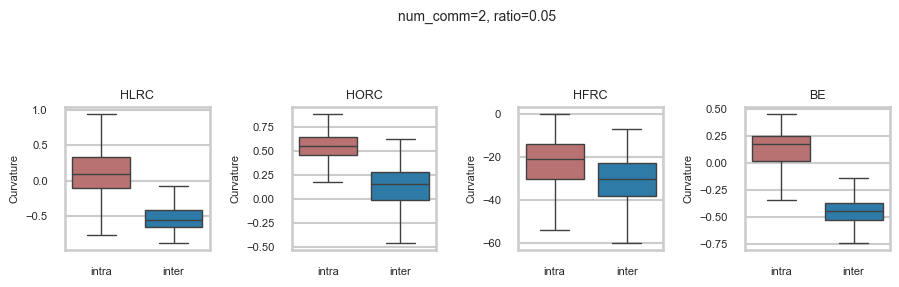

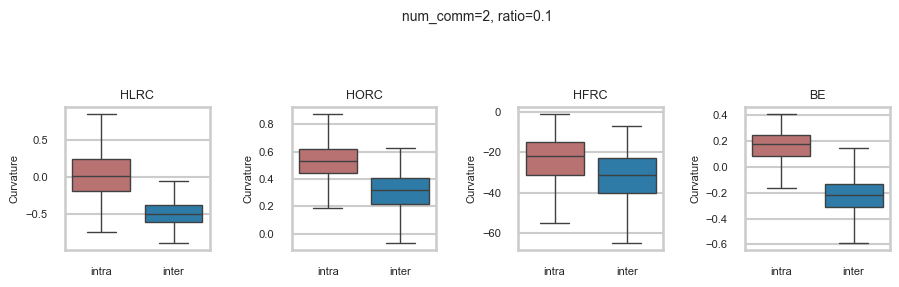

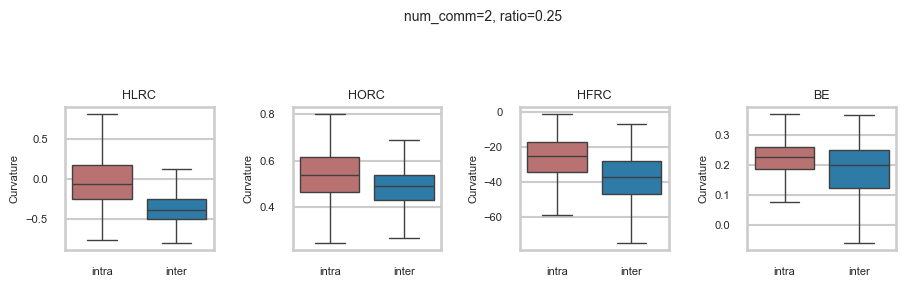

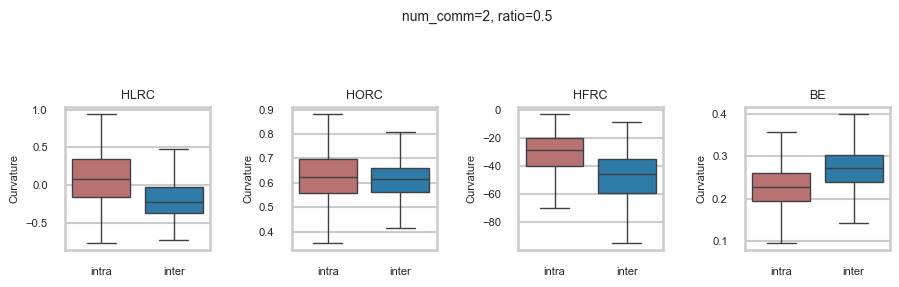

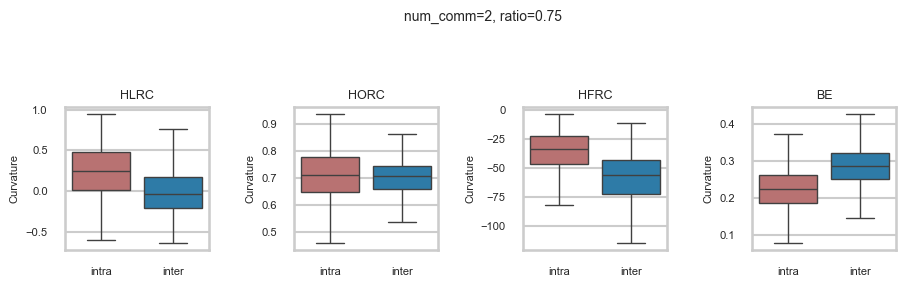

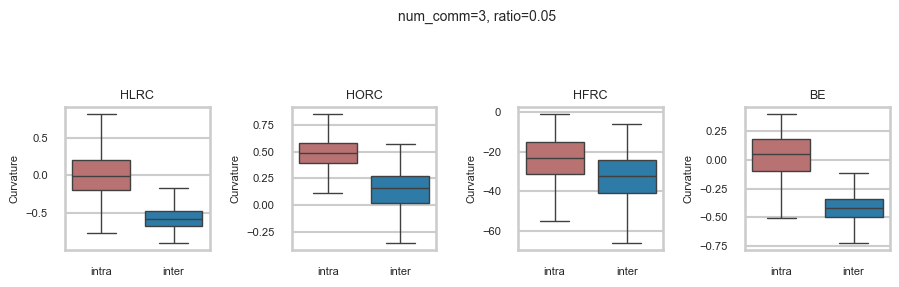

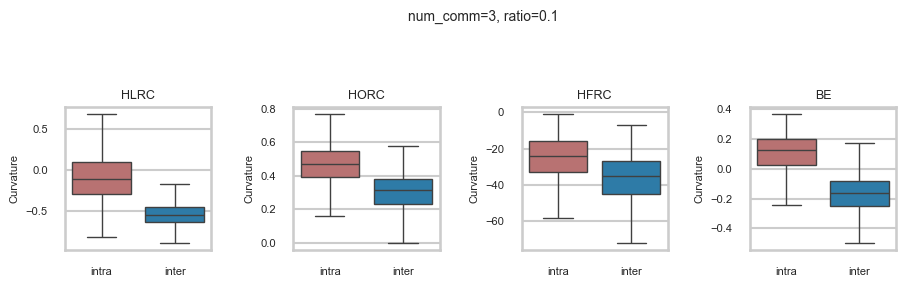

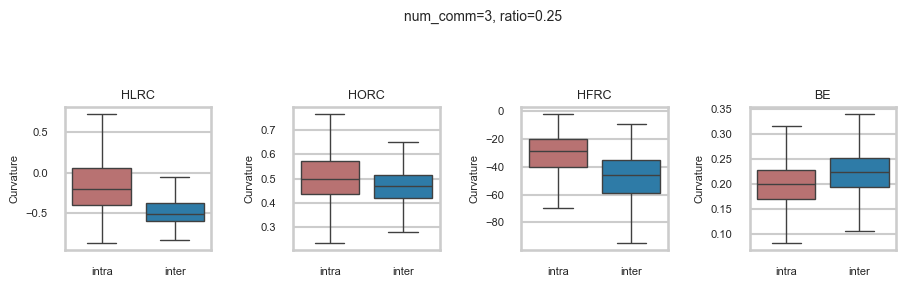

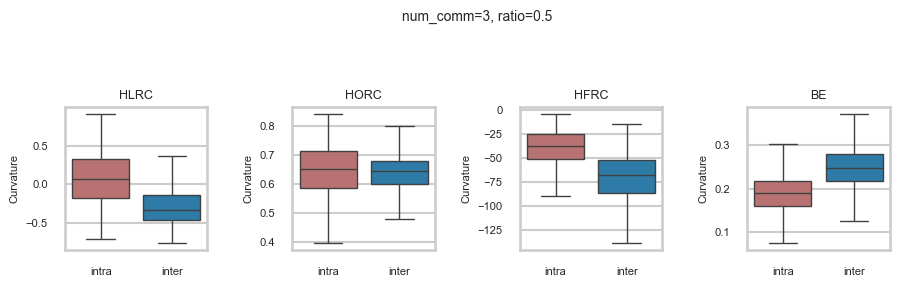

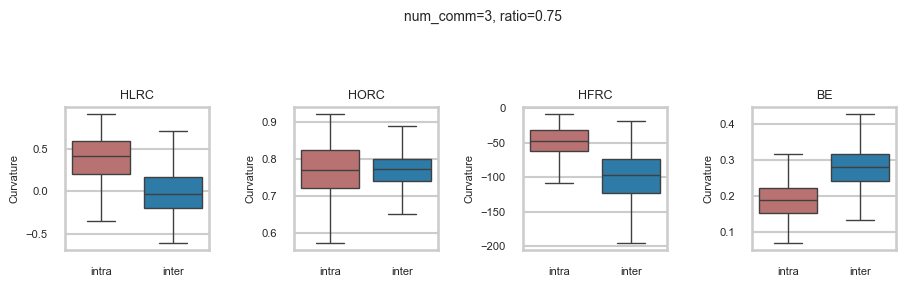

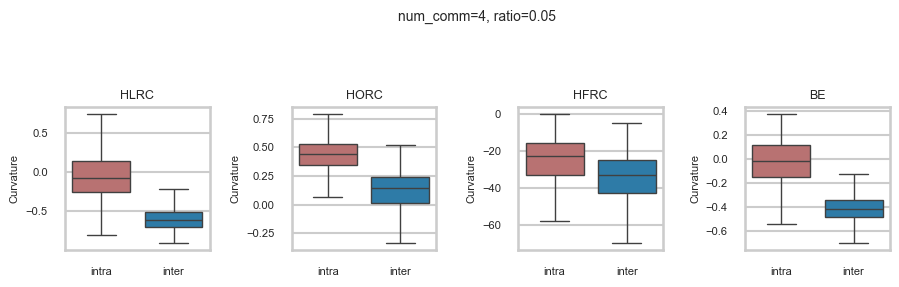

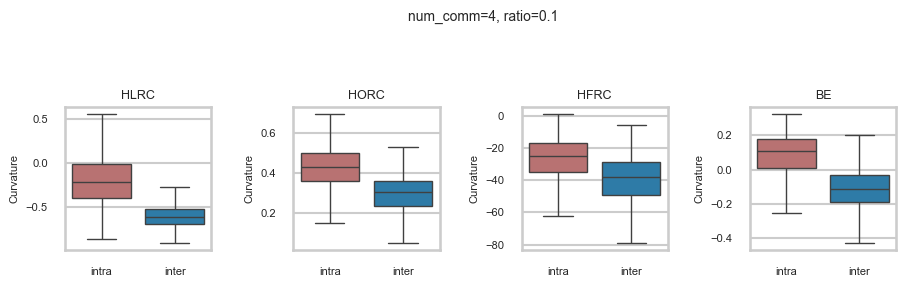

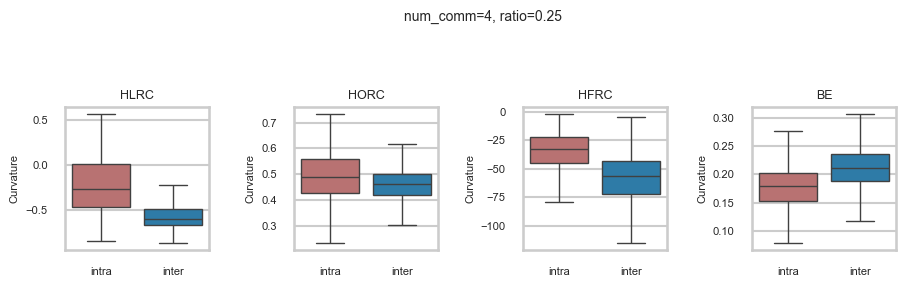

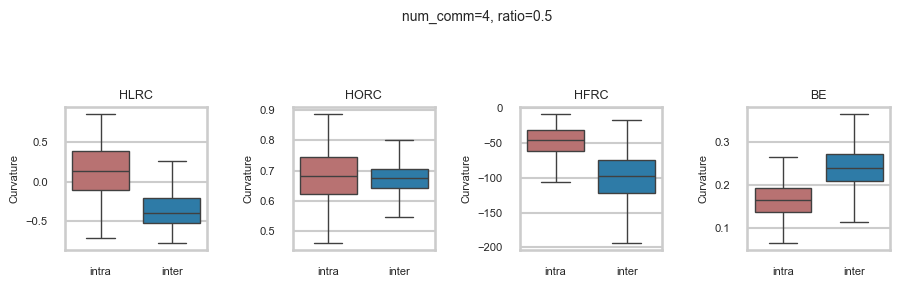

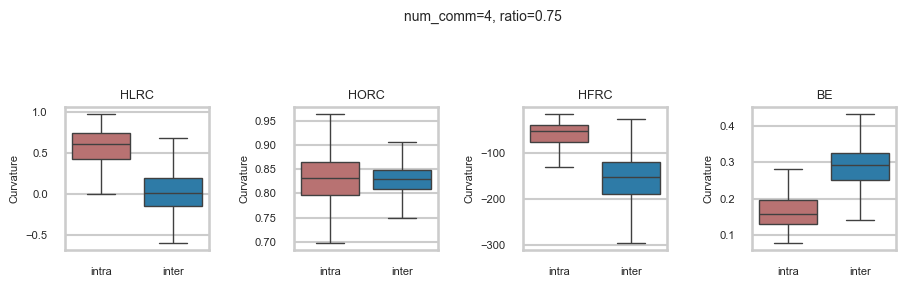

In [ ]:
curv_cols = ["hlrc", "horc", "hfrc", "be"]
palette = {"intra": "#c46666", "inter": "#1a80bb"}

for config_idx, group in nu_df.groupby("config_idx"):
    if group.empty:
        continue

    n_comm = group.num_comms.iloc[0]
    if n_comm !=2: # only plot out 2comm case for example
        continue
    ratio = group.inter_to_intra_ratio.iloc[0]

    plot_df = group.melt(
        id_vars="edge_label",
        value_vars=curv_cols,
        var_name="curvature_type",
        value_name="curvature",
    )

    fig, axes = plt.subplots(1, len(curv_cols), figsize=(10, 3), sharey=False)
    handles = labels = None

    for ax, (curvature, title) in zip(axes, zip(curv_cols, map(str.upper, curv_cols))):
        subset = plot_df[plot_df["curvature_type"] == curvature]
    
        sns.boxplot(
            data=subset,
            x="edge_label",
            y="curvature",
            hue="edge_label",
            palette=palette,
            order=["intra", "inter"],
            hue_order=["intra", "inter"],
            showfliers=False,
            ax=ax,
        )

        ax.set_title(title, fontsize=9)
        ax.set_xlabel("")
        ax.set_ylabel("Curvature", fontsize=8)
        ax.tick_params(axis="x", labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

        legend = ax.get_legend()
        if legend is not None:
            if handles is None:
                handles = legend.legend_handles
                labels = [t.get_text() for t in legend.texts]
            legend.remove()

    if handles is not None:
        fig.legend(
            handles,
            labels,
            title="edge_label",
            loc="upper right",
            bbox_to_anchor=(1.02, 0.98),
            fontsize=8,
            title_fontsize=9,
        )

    fig.suptitle(f"num_comm={n_comm}, ratio={ratio}", fontsize=10)
    fig.tight_layout(rect=[0, 0, 0.94, 0.94])
    plt.show()


In [ ]:
curv_cols = ["hlrc", "horc", "hfrc", "be"]
palette = {"intra": "#c46666", "inter": "#1a80bb"}
configs = [cfg for cfg, g in nu_df.groupby("config_idx") if not g.empty]
n_configs = len(configs)

fig, axes = plt.subplots(
    n_configs,
    len(curv_cols),
    figsize=(len(curv_cols) * 3.0, n_configs * 2.6),
    sharex=False,
    sharey=False,
    squeeze=False,
)

legend_handles = legend_labels = None

for row_idx, config_idx in enumerate(configs):
    group = nu_df[nu_df["config_idx"] == config_idx]
    n_comm = group.num_comms.iloc[0]
    ratio = group.inter_to_intra_ratio.iloc[0]

    plot_df = group.melt(
        id_vars="edge_label",
        value_vars=curv_cols,
        var_name="curvature_type",
        value_name="curvature",
    )

    for col_idx, curvature in enumerate(curv_cols):
        ax = axes[row_idx, col_idx]
        subset = plot_df[plot_df["curvature_type"] == curvature]

        sns.boxplot(
            data=subset,
            x="edge_label",
            y="curvature",
            hue="edge_label",
            palette=palette,
            order=["intra", "inter"],
            hue_order=["intra", "inter"],
            showfliers=False,
            ax=ax,
        )

        ax.set_title(f"{curvature.upper()}", fontsize=9)
        ax.set_xlabel("")
        ax.set_ylabel("Curvature", fontsize=8)
        ax.tick_params(axis="x", labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

        legend = ax.get_legend()
        if legend:
            if legend_handles is None:
                legend_handles = legend.legend_handles
                legend_labels = [t.get_text() for t in legend.texts]
            legend.remove()

    axes[row_idx, 0].text(
        0.0,
        1.1,
        f"config_idx={config_idx}, num_comm={n_comm}, ratio={ratio}",
        transform=axes[row_idx, 0].transAxes,
        fontsize=9,
    )

if legend_handles is not None:
    fig.legend(
        legend_handles,
        legend_labels,
        title="edge_label",
        loc="upper right",
        bbox_to_anchor=(0.99, 0.99),
        fontsize=8,
        title_fontsize=9,
    )

fig.tight_layout(rect=[0, 0, 0.95, 0.97])
fig.suptitle("Curvature distributions by config", fontsize=12, y=0.99)
fig.savefig("figures/nu_hsbm_boxplots.pdf")
plt.close(fig)


## Average Hellinger Distance

In [43]:
NU_CURVATURE_ORDER = ['hlrc', 'horc', 'hfrc','be']

records = []
for (config_id,hg_id), group in nu_df.groupby(['config_idx','hg_idx']):
    for curvature in NU_CURVATURE_ORDER:
        if curvature not in group.columns:
            continue
        data = group[['edge_label', curvature]].dropna()
        inter = data.loc[data['edge_label'] == 'inter', curvature].to_numpy()
        intra = data.loc[data['edge_label'] == 'intra', curvature].to_numpy()
        if len(inter) == 0 or len(intra) == 0:
            continue
        distance = hellinger_distance(intra, inter)
        records.append({
            'config_idx': config_id,
            'hg_idx': hg_id,
            'curvature_type': curvature,
            'hellinger_distance': distance,
            'n_comm': group.num_comms.unique()[0],
            'ratio':group.inter_to_intra_ratio.unique()[0],
            'inter_count': len(inter),
            'intra_count': len(intra),
        })

nu_hellinger_df = pd.DataFrame(records)
nu_hellinger_df

,config_idx,hg_idx,curvature_type,hellinger_distance,n_comm,ratio,inter_count,intra_count
0,0,0,hlrc,0.972340,2,0.05,16,84
1,0,0,horc,0.975177,2,0.05,16,104
2,0,0,hfrc,0.734632,2,0.05,16,104
3,0,0,be,0.987667,2,0.05,16,104
4,0,1,hlrc,1.000000,2,0.05,7,101
...,...,...,...,...,...,...,...,...
5945,14,1498,be,1.000000,4,0.75,239,1
5946,14,1499,hlrc,1.000000,4,0.75,237,2
5947,14,1499,horc,0.953656,4,0.75,237,3
5948,14,1499,hfrc,1.000000,4,0.75,237,3


In [44]:
pivot = nu_hellinger_df.pivot_table(
        index=['n_comm','ratio'],
        columns='curvature_type',
        values='hellinger_distance'
    )
display(pivot)

curvature_type        be      hfrc      hlrc      horc
n_comm ratio                                          
2      0.05     0.994661  0.785330  0.978594  0.971398
       0.10     0.981889  0.717657  0.951891  0.905153
       0.25     0.808374  0.688045  0.886338  0.767658
       0.50     0.842300  0.737042  0.887037  0.765614
       0.75     0.883586  0.822565  0.899045  0.833437
3      0.05     0.971363  0.644546  0.951023  0.916166
       0.10     0.920702  0.611527  0.902969  0.791492
       0.25     0.704950  0.676088  0.844978  0.665978
       0.50     0.875226  0.838317  0.907687  0.799110
       0.75     0.947267  0.931835  0.950114  0.901845
4      0.05     0.933238  0.570999  0.929873  0.859952
       0.10     0.844841  0.567346  0.863683  0.711505
       0.25     0.733816  0.728869  0.852320  0.672334
       0.50     0.926814  0.918830  0.949066  0.868371
       0.75     0.983483  0.976597  0.984431  0.949211

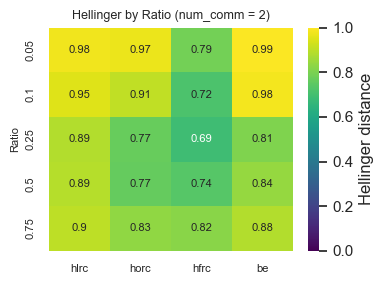

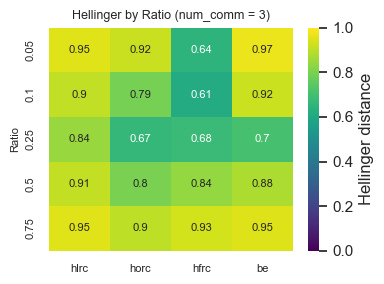

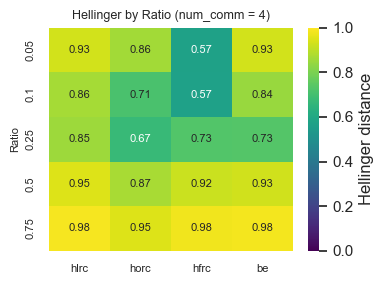

In [55]:
sns.set_theme(style="whitegrid")

for n_comm in sorted(pivot.index.get_level_values("n_comm").unique()):
    heat = pivot.xs(n_comm, level="n_comm")
    heat = heat.reindex(columns=[c for c in NU_CURVATURE_ORDER if c in heat.columns])

    plt.figure(figsize=(4, max(2.5, 0.6 * len(heat))))
    ax = sns.heatmap(
        heat,
        annot=True,
        cmap="viridis",
        vmin=0.0,
        vmax=1.0,
        cbar_kws={"label": "Hellinger distance"},
        annot_kws={"size":8},
    )
    ax.set_title(f"Hellinger by Ratio (num_comm = {n_comm})", fontsize=9)
    ax.set_xlabel("")
    ax.set_ylabel("Ratio", fontsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    plt.tight_layout()
    # plt.savefig(f"figures/heatmap_nu_hsbm_hellinger_dist_ncom{n_comm}.pdf")
    plt.show()

## HORC allconfig

In [ ]:
NU_DATA_PATH = Path("derived_data/nu_hsbm_horc_2com.csv")
if not NU_DATA_PATH.exists():
    raise FileNotFoundError(f'Dataset not found at {NU_DATA_PATH!s}. Make sure `compute_horc_hsbm.jl` has been executed.')

nu_df = pd.read_csv(NU_DATA_PATH)

nu_df['edge_size'] = nu_df['members'].apply(lambda x: len(_parse_members(x)))
nu_df['members'] =  nu_df['members'].apply(lambda x: _parse_members(x))

In [133]:
import re

def decode_horc_column(col: str):
    if col == "horc":
        return "uw_clique", "mean", 0.0  # legacy column

    match = re.fullmatch(r"horc_([a-z0-9_]+)_([a-z0-9_]+)_a([\dp]+)", col, flags=re.I)
    if not match:
        raise ValueError(f"Unrecognized HORC column name: {col}")
    dispersion, aggregation, alpha_token = match.groups()
    alpha = float(alpha_token.replace("p", "."))
    return dispersion, aggregation, alpha


horc_cols = [c for c in nu_df.columns if c.startswith("horc")]
if not horc_cols:
    raise ValueError("No HORC columns found in dataset.")

long_frames = []
base_cols = ["config_idx", "hg_idx", "edge", "members", "edge_label","inter_to_intra_ratio"]

for col in horc_cols:
    dispersion, aggregation, alpha = decode_horc_column(col)
    frame = nu_df[base_cols].copy()
    frame["horc"] = nu_df[col]
    frame["dispersion"] = dispersion
    frame["agg"] = aggregation
    frame["alpha"] = alpha
    long_frames.append(frame)

horc_long = pd.concat(long_frames, ignore_index=True)
horc_long = horc_long[
    ["config_idx", "hg_idx", "inter_to_intra_ratio", "edge", "members", "edge_label", "horc", "dispersion", "agg", "alpha"]
]
horc_long = horc_long.dropna()
horc_long.to_csv("derived_data/nu_hsbm_horc_4com_clean.csv", index=False)

In [134]:
records = []
for (config_id,hg_id), group in horc_long.groupby(['config_idx','hg_idx']):
    for horc_config, sub_group in group.groupby(['dispersion','agg','alpha']):
        data = sub_group[['edge_label', 'horc']].dropna()
        inter = data.loc[data['edge_label'] == 'inter', 'horc'].to_numpy()
        intra = data.loc[data['edge_label'] == 'intra', 'horc'].to_numpy()
        if len(inter) == 0 or len(intra) == 0:
            continue
        distance = hellinger_distance(intra, inter)
        records.append({
            'config_idx': config_id,
            'hg_idx': hg_id,
            'dispersion': horc_config[0],
            'agg': horc_config[1],
            "alpha":horc_config[2],
            'hellinger_distance': distance,
            'ratio':sub_group.inter_to_intra_ratio.unique()[0],
        })
nu_horc_hellinger_df = pd.DataFrame(records)
nu_horc_hellinger_df

,config_idx,hg_idx,dispersion,agg,alpha,hellinger_distance,ratio
0,10,1000,uw_clique,max,0.0,0.958759,0.05
1,10,1000,uw_clique,max,0.1,0.946937,0.05
2,10,1000,uw_clique,max,0.2,0.942474,0.05
3,10,1000,uw_clique,max,0.3,0.950765,0.05
4,10,1000,uw_clique,max,0.4,0.940899,0.05
...,...,...,...,...,...,...,...
17587,14,1499,w_clique,mean,0.1,0.927188,0.75
17588,14,1499,w_clique,mean,0.2,0.921948,0.75
17589,14,1499,w_clique,mean,0.3,0.917000,0.75
17590,14,1499,w_clique,mean,0.4,0.897290,0.75


In [135]:
pivot = nu_horc_hellinger_df.pivot_table(
        index=['ratio','alpha'],
        columns=['dispersion','agg'],
        values='hellinger_distance'
    )
display(pivot)

dispersion  uw_clique             uw_star            w_clique          
agg               max      mean       max      mean       max      mean
ratio alpha                                                            
0.05  0.0    0.975580  0.859952  0.994074  0.952176  0.991803  0.916124
      0.1    0.976208  0.865801  0.993190  0.967187  0.992657  0.914700
      0.2    0.974088  0.859992  0.993442  0.966845  0.992496  0.909945
      0.3    0.972611  0.851127  0.992476  0.965479  0.991830  0.907517
      0.4    0.970864  0.842761  0.991859  0.963161  0.991107  0.898573
      0.5    0.968177  0.832546  0.991227  0.958795  0.990251  0.892081
0.10  0.0    0.859628  0.711505  0.940286  0.823365  0.932559  0.796685
      0.1    0.866934  0.724280  0.943193  0.893552  0.940603  0.815498
      0.2    0.860372  0.708195  0.939884  0.893360  0.937809  0.809187
      0.3    0.852472  0.696761  0.935575  0.887703  0.933987  0.796830
      0.4    0.841378  0.678570  0.930719  0.881416  0.929617  0.784635
      0.5    0.831348  0.663085  0.923765  0.871979  0.922347  0.772592
0.25  0.0    0.728280  0.672334  0.738512  0.642722  0.760654  0.663212
      0.1    0.712616  0.646928  0.814163  0.764874  0.778601  0.701879
      0.2    0.691436  0.618276  0.807300  0.755429  0.762466  0.676430
      0.3    0.667770  0.590138  0.791017  0.737245  0.747850  0.658281
      0.4    0.639975  0.559105  0.773373  0.715551  0.729247  0.627573
      0.5    0.607238  0.525952  0.754251  0.693950  0.705716  0.600451
0.50  0.0    0.873337  0.868371  0.843425  0.820813  0.852378  0.824790
      0.1    0.864768  0.849201  0.891967  0.851595  0.861696  0.826392
      0.2    0.857472  0.835295  0.880957  0.832681  0.847946  0.811811
      0.3    0.839238  0.814776  0.868817  0.816556  0.830499  0.790713
      0.4    0.825360  0.789395  0.854331  0.797260  0.813785  0.769814
      0.5    0.802800  0.761465  0.838642  0.772714  0.792651  0.741643
0.75  0.0    0.949583  0.949211  0.943894  0.952658  0.954994  0.945768
      0.1    0.950156  0.949309  0.967924  0.951495  0.953877  0.949313
      0.2    0.947329  0.944931  0.969410  0.950461  0.951730  0.947739
      0.3    0.944702  0.940806  0.965780  0.945837  0.948739  0.942430
      0.4    0.944091  0.940108  0.964740  0.942716  0.950214  0.938177
      0.5    0.938734  0.931761  0.963913  0.940695  0.947756  0.932424

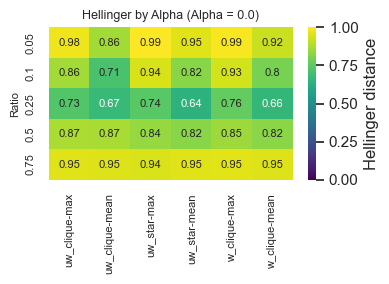

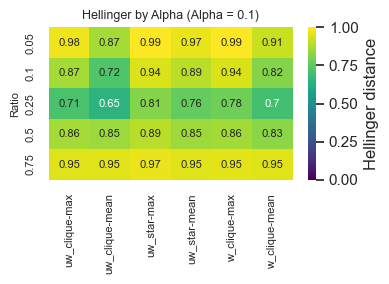

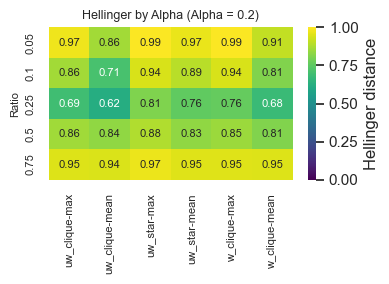

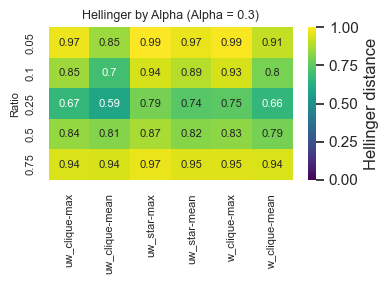

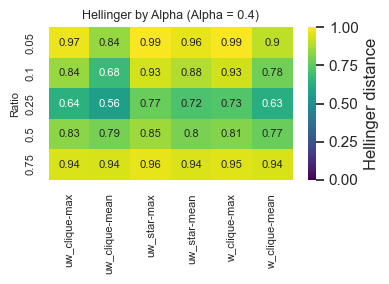

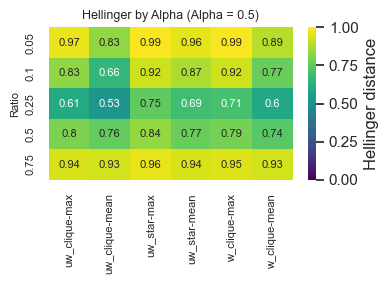

In [136]:
sns.set_theme(style="whitegrid")

for alpha in sorted(pivot.index.get_level_values("alpha").unique()):
    heat = pivot.xs(alpha, level="alpha")
    plt.figure(figsize=(4, max(2.5, 0.6 * len(heat))))
    ax = sns.heatmap(
        heat,
        annot=True,
        cmap="viridis",
        vmin=0.0,
        vmax=1.0,
        cbar_kws={"label": "Hellinger distance"},
        annot_kws={"size":8},
    )
    ax.set_title(f"Hellinger by Alpha (Alpha = {alpha})", fontsize=9)
    ax.set_xlabel("")
    ax.set_ylabel("Ratio", fontsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    plt.tight_layout()
    plt.savefig(f"figures/nu_hsbm_heatmap_horc_4ncomm_{alpha*10:.0f}.pdf")
    plt.show()